# Gaussian Mixture Models
Michael Burkhardt <<burkhardt.5@osu.edu>>

Based on Scikit-Learn examples:
* [Gaussian Mixture Model Selection](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html)
* [GMM Covariances](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification, make_regression, make_blobs
from sklearn.model_selection import train_test_split

from sklearn.mixture import GaussianMixture
import itertools
from scipy import linalg

## Generate data

### Generate test data.
Run any of the next four cells to generate an example dataset.

In [2]:
# Generate globular data
# with specific centers and standard deviations
X1, Y1 = make_blobs(n_samples=500,
                    n_features=2,
                    centers=[(-4,0), (0,0)],
                    cluster_std=[2, 0.5],
                    random_state=465226429)

In [3]:
# Alternatively, make non-globular clusters
# to illustrate "full" model
X1, Y1 = make_classification(n_samples=500,
                             n_features=2, 
                             n_redundant=0,
                             n_informative=2,
                             n_clusters_per_class=1,
                             class_sep=2.0,
                             n_classes=3,
                             random_state=873267430)

In [4]:
# Create aligned clusters -- use this cell to force
# the GMM model selection step to use a "tied" model
X1, Y1 = make_classification(n_samples=200,
                             n_features=2, 
                             n_redundant=0,
                             n_informative=2,
                             n_clusters_per_class=1,
                             class_sep=2.0,
                             n_classes=1,
                             random_state=920721562)

X2 = X1.copy()
X2[:,0] = X2[:,0] - 4

X1 = np.append(X1, X2).reshape(-1,2)
X1.shape

(400, 2)

In [5]:
# Manufacture some data to illustrate the 'diag' model
np.random.seed(202254036)
Ax = np.random.randn(200,2)
Ax[:,0] = Ax[:,0] * 0.25 - 3

Bx = np.random.randn(200,2)
Bx[:,1] = Bx[:,1] * 0.25 + 2

X1 = np.append(Ax, Bx).reshape(-1,2)

## Visualize the dataset

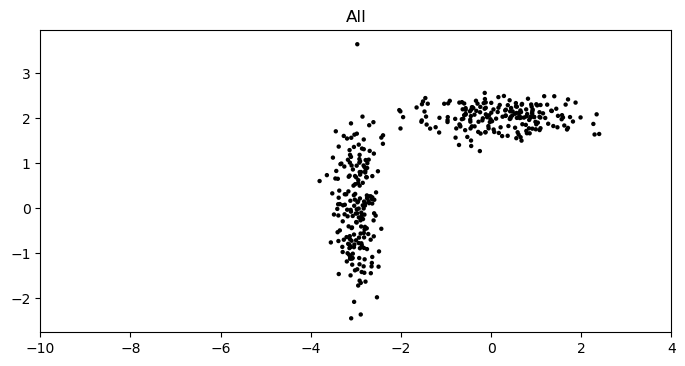

In [6]:
# Visualize the entire dataset
fig = plt.figure(figsize=(10, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect=1)
# plot all using same marker
ax.scatter(X1[:, 0], X1[:, 1], marker='.', c='k', s=40, edgecolor='')
# Plot classes using different markers:
#ax.scatter(X1[Y1==0, 0], X1[Y1==0, 1], marker='$*$', c='k', s=40, edgecolor='')
#ax.scatter(X1[Y1==1, 0], X1[Y1==1, 1], marker='o', c='k', s=20, edgecolor='')
ax.set_title('All')
plt.xlim(-10, 4)
plt.show()

In [7]:
# Find the best Gaussian Mixture Model
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
#cv_types = ['full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X1)
        bic.append(gmm.bic(X1))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic) # convert to Numpy array
print('Best model: {}'.format(best_gmm.covariance_type))

Best model: diag


In [8]:
# Display the covariance matrices
best_gmm.covariances_

array([[0.89470616, 0.06128992],
       [0.0654914 , 0.94058411]])

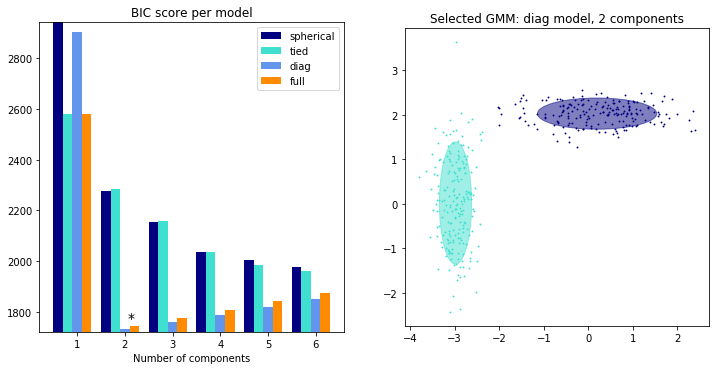

In [9]:
# Plot the BIC scores and clustered points side by side

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
bars = []

plt.figure(figsize=(12, 5))
spl = plt.subplot(1, 2, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

# Mark the selected (best) model with an asterisk
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '$*$', fontsize=14)

spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(1, 2, 2, aspect=1.0)
Y_ = best_gmm.predict(X1)
for i, (mean, cov, color) in enumerate(zip(best_gmm.means_, best_gmm.covariances_, color_iter)):
    
    # Convert covariance to square matrix
    if best_gmm.covariance_type == 'full':
        cov = best_gmm.covariances_[i][:2, :2]
    elif best_gmm.covariance_type == 'tied':
        cov = best_gmm.covariances_[:2, :2]
    elif best_gmm.covariance_type == 'diag':
        cov = np.diag(best_gmm.covariances_[i][:2])
    elif best_gmm.covariance_type == 'spherical':
        cov = np.eye(best_gmm.means_.shape[1]) * best_gmm.covariances_[i]

    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X1[Y_ == i, 0], X1[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.title('Selected GMM: {} model, {} components'.format(best_gmm.covariance_type, best_gmm.n_components))
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

Best model marked with an asterisk $(*)$

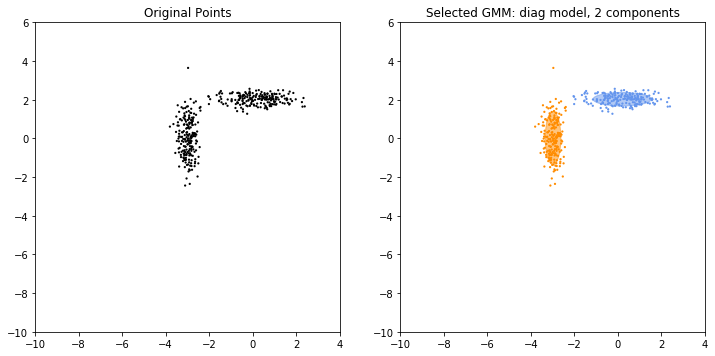

In [10]:
# Plot unclustered and clustered points side by side
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(X1[:, 0], X1[:, 1], marker='.', c='k', s=20, edgecolor='')
ax1.set_title('Original Points')
ax1.set_xlim(-10, 4)
ax1.set_ylim(-10, 6)


# Plot the winner
splot = plt.subplot(1, 2, 2)
splot.set_xlim(-10, 4)
splot.set_ylim(-10, 6)
Y_ = best_gmm.predict(X1)
for i, (mean, cov, color) in enumerate(zip(best_gmm.means_, best_gmm.covariances_, color_iter)):

        
    # Convert covariance to square matrix
    if best_gmm.covariance_type == 'full':
        cov = best_gmm.covariances_[i][:2, :2]
    elif best_gmm.covariance_type == 'tied':
        cov = best_gmm.covariances_[:2, :2]
    elif best_gmm.covariance_type == 'diag':
        cov = np.diag(best_gmm.covariances_[i][:2])
    elif best_gmm.covariance_type == 'spherical':
        cov = np.eye(best_gmm.means_.shape[1]) * best_gmm.covariances_[i]

    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X1[Y_==i, 0], X1[Y_==i, 1], marker='.', s=20, edgecolor='', color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.title('Selected GMM: {} model, {} components'.format(best_gmm.covariance_type, best_gmm.n_components))
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()